In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint
import unicodedata
import nltk
import lux

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from glob import glob
import string
import funcy as fp
from gensim import models
from gensim.corpora import Dictionary, MmCorpus

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# I - Read Data 

In [2]:
global_df = pd.read_csv('global_df.csv')

In [3]:
global_df = global_df.iloc[global_df.astype(str).drop_duplicates().index]

In [4]:
# getting rows with topic/post content
global_df = global_df[global_df.cooked != '0']

### Clean Text

In [5]:
# Remove html code <p>
def remove_html(text):
    pattern = re.compile('<[^<]+?>')
    text = re.sub(pattern, ' ', text)
    return text

In [6]:
global_df['noHTML_text'] = global_df.cooked.apply(lambda x: remove_html(x))

In [7]:
# Function to clean text

def clean_text(text):
    
    # Remove html code <p>
    pattern = re.compile('<[^<]+?>')
    text = re.sub(pattern, ' ', text)
    
    # Remove hyperlinks
    text = re.sub(r'https?:\/\/\S+','',text)
    
    # lowercase
    text =text.lower()
    

    # Remove ticks, apostrophes and letters after " 's "
    text = re.sub("\’\w+", '', text)
    text = re.sub("\'\w+", '', text)
    
    
    # Remove all types of nums
    text = re.sub(r'\b\d+(?:\.\d+)?\s+', '', text)
    text = re.sub(r"\b\d+\b", ' ', text)
    
    # Remove specific punctuations
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    
    # Remove accents "é"
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    # remove the hashtag symbol #
    text = re.sub(r'#','',text)
   # text = re.sub(r'[-./]', ' ', text)
    
    return text

In [8]:
global_df['cleaned_text'] = global_df.cooked.apply(lambda x: clean_text(x))

# Compare between Original Text & Clean Text

pd.options.display.max_colwidth = 300
global_df[['cooked', 'cleaned_text']].head(1)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [9]:
df = global_df.groupby(['topic_id'], as_index = False).agg({'cleaned_text': ' '.join})

In [10]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df.cleaned_text.values.tolist()))

print(data_words[:1])

[['replace', 'this', 'first', 'paragraph', 'with', 'short', 'description', 'of', 'your', 'new', 'category', 'this', 'guidance', 'will', 'appear', 'in', 'the', 'category', 'selection', 'area', 'so', 'try', 'to', 'keep', 'it', 'below', 'characters', 'until', 'you', 'edit', 'this', 'text', 'or', 'create', 'topics', 'this', 'category', 'won', 'appear', 'on', 'the', 'categories', 'page', 'use', 'the', 'following', 'paragraphs', 'for', 'longer', 'description', 'as', 'well', 'as', 'to', 'establish', 'any', 'category', 'guidelines', 'or', 'rules', 'some', 'things', 'to', 'consider', 'in', 'any', 'discussion', 'replies', 'below', 'what', 'is', 'this', 'category', 'for', 'why', 'should', 'people', 'select', 'this', 'category', 'for', 'their', 'topic', 'how', 'is', 'this', 'different', 'than', 'the', 'other', 'categories', 'we', 'already', 'have', 'do', 'we', 'need', 'this', 'category', 'should', 'we', 'merge', 'this', 'with', 'another', 'category', 'or', 'split', 'it', 'into', 'more', 'categorie

In [11]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], min_count=5, threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['replace', 'this', 'first', 'paragraph', 'with', 'short', 'description', 'of', 'your', 'new', 'category', 'this', 'guidance', 'will', 'appear', 'in', 'the', 'category', 'selection', 'area', 'so', 'try', 'to', 'keep', 'it', 'below', 'characters', 'until', 'you', 'edit', 'this', 'text', 'or', 'create', 'topics', 'this', 'category', 'won', 'appear', 'on', 'the', 'categories', 'page', 'use', 'the', 'following', 'paragraphs', 'for', 'longer', 'description', 'as', 'well', 'as', 'to', 'establish', 'any', 'category', 'guidelines', 'or', 'rules', 'some', 'things', 'to', 'consider', 'in', 'any', 'discussion', 'replies', 'below', 'what', 'is', 'this', 'category', 'for', 'why', 'should', 'people', 'select', 'this', 'category', 'for', 'their', 'topic', 'how', 'is', 'this', 'different', 'than', 'the', 'other', 'categories', 'we', 'already', 'have', 'do', 'we', 'need', 'this', 'category', 'should', 'we', 'merge', 'this', 'with', 'another', 'category', 'or', 'split', 'it', 'into', 'more', 'categories

In [12]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
extra_words = ['ill', 'hi', 'im', 'ive', 'dont', 'hello', 'hey', 'like', 'thanks', 'maybe', 'q', 'e g', 'think', 'good', 'com', 'hop',
             'thats', 'c', 'b', 'l', 'il', 'x', 'z', 'v', 'f', 'e', 'q', 'isnt', 'wont', 'yes', 'want', 'let', 'know', 'id', 'g', 'thing',
             'thank', 'come', 'mm', 'w', 'non', 'day', 'look', 'baby', 'n', 'lot', 'way', 'use', 'try', 'hour', 'couple', 'week', 'ago',
             'i', 'h', 'et', 'img', 'cool', 'year', 'u', 'need', 'nice', 'guy', 'boy', 'pm', '3rd', 'pretty', 'sure', 'bit', 'week', 'minute',
             'png', 'screen', 'shot', 'sans', 'serif', 'mon', 'mar', 'kb', 'gmt', 'arial', 'helvetica', 'feb', 'long', 'period', 'time', 'font', 
             'size', 'medium', 'interested', 'dat', 'drank', 'dad', 'bottle', 'turn', 'number', 'everyday', 'follow', 'life', 'jar', 'j','www',
             'happen', 'yeah', 'wish', 'love', 'cheer', 'fun', 'later', 'bad', 'unfortunately', 'org', 'july', 'ki', 'february', 'month', 'saw',
             'potentially', 'effect', 'test', 'month', 'note', 'thing''21st', 'hf', 'day', 'rr', 'lf', 'wait', 'yay', 'especially', 'feel', 'go',
            '100s', 'bin', 'thing', 'way', 'things', 'people', 'minute']

stop_words.extend(extra_words)

In [13]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN'])

print(data_lemmatized[:1])

[['paragraph', 'description', 'category', 'guidance', 'category', 'selection', 'area', 'character', 'text', 'topic', 'category', 'category', 'page', 'paragraph', 'description', 'category', 'guideline', 'rule', 'discussion', 'category', 'category', 'topic', 'category', 'category', 'category', 'split', 'category']]


# 1: gensim.models.ldamodel.LdaModel

In [14]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
id2word.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
id2word.compactify()
# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 11), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 2)]]


In [15]:
vocab_length = len(id2word)

In [16]:
print('Number of unique tokens: %d' % len(id2word))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 1523
Number of documents: 2117


In [17]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=123,
                                           chunksize=1000,
                                           passes=50,
                                           iterations=100,
                                           per_word_topics=True,
                                           alpha='asymmetric',
                                           eta=.001,
                                           eval_every =1
                                           )
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [18]:
%%time
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=10, step=1)

CPU times: user 37min 12s, sys: 3.07 s, total: 37min 15s
Wall time: 37min 22s


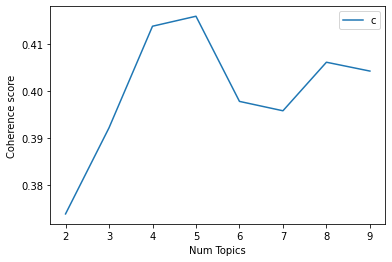

In [19]:
# Show graph
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [20]:
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3738
Num Topics = 3  has Coherence Value of 0.3922
Num Topics = 4  has Coherence Value of 0.4138
Num Topics = 5  has Coherence Value of 0.4159
Num Topics = 6  has Coherence Value of 0.3978
Num Topics = 7  has Coherence Value of 0.3958
Num Topics = 8  has Coherence Value of 0.4061
Num Topics = 9  has Coherence Value of 0.4042


In [21]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=20)) 

[(0,
  '0.054*"app" + 0.021*"user" + 0.014*"api" + 0.014*"export" + 0.013*"data" + '
  '0.012*"track" + 0.010*"mood" + 0.010*"tool" + 0.010*"activity" + '
  '0.010*"work" + 0.009*"tracking" + 0.008*"health" + 0.008*"tracker" + '
  '0.008*"fitbit" + 0.007*"example" + 0.007*"list" + 0.007*"value" + '
  '0.007*"phone" + 0.007*"emfit_q" + 0.007*"access"'),
 (1,
  '0.020*"self" + 0.017*"health" + 0.015*"question" + 0.014*"research" + '
  '0.014*"work" + 0.011*"project" + 0.010*"study" + 0.009*"tool" + '
  '0.009*"tracking" + 0.008*"community" + 0.008*"information" + 0.007*"part" + '
  '0.007*"idea" + 0.007*"experience" + 0.006*"survey" + 0.006*"forum" + '
  '0.006*"technology" + 0.006*"link" + 0.006*"year" + 0.006*"data"'),
 (2,
  '0.043*"sleep" + 0.032*"hrv" + 0.021*"measure" + 0.017*"amp" + '
  '0.015*"device" + 0.013*"measurement" + 0.011*"bed" + 0.011*"stress" + '
  '0.010*"night" + 0.010*"body" + 0.010*"score" + 0.009*"minute" + '
  '0.009*"experiment" + 0.009*"meditation" + 0.009*"act

In [22]:
optimal_model.save('44nice_model.model')

In [23]:
import lux

In [24]:
from imp import reload

In [25]:
pyLDAvis.enable_notebook()
vis_data = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word, mds='mmds')
pyLDAvis.display(vis_data)

/home/criuser/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/criuser/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/criuser/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/criuser/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/criuser/miniconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: Depre

# 2: sklearn

In [35]:
from time import time
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

n_samples = 2000
n_features = 1000
n_components = 10
n_top_words = 20


def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


# Load the 20 newsgroups dataset and vectorize it. We use a few heuristics
# to filter out useless terms early on: the posts are stripped of headers,
# footers and quoted replies, and common English words, words occurring in
# only one document or in at least 95% of the documents are removed.

t0 = time()

data_samples = global_df.lemma_LDA_text
print("done in %0.3fs." % (time() - t0))

# Use tf-idf features for NMF.

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                   max_features=n_features)
t0 = time()
tfidf = tfidf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))

# Use tf (raw term count) features for LDA.
print("Extracting tf features for LDA...")
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                max_features=n_features,
                                stop_words='english')
t0 = time()
tf = tf_vectorizer.fit_transform(data_samples)
print("done in %0.3fs." % (time() - t0))
print()

done in 0.001s.
done in 0.198s.
Extracting tf features for LDA...
done in 0.185s.



Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=2000 and n_features=1000...


/home/criuser/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).


done in 0.728s.


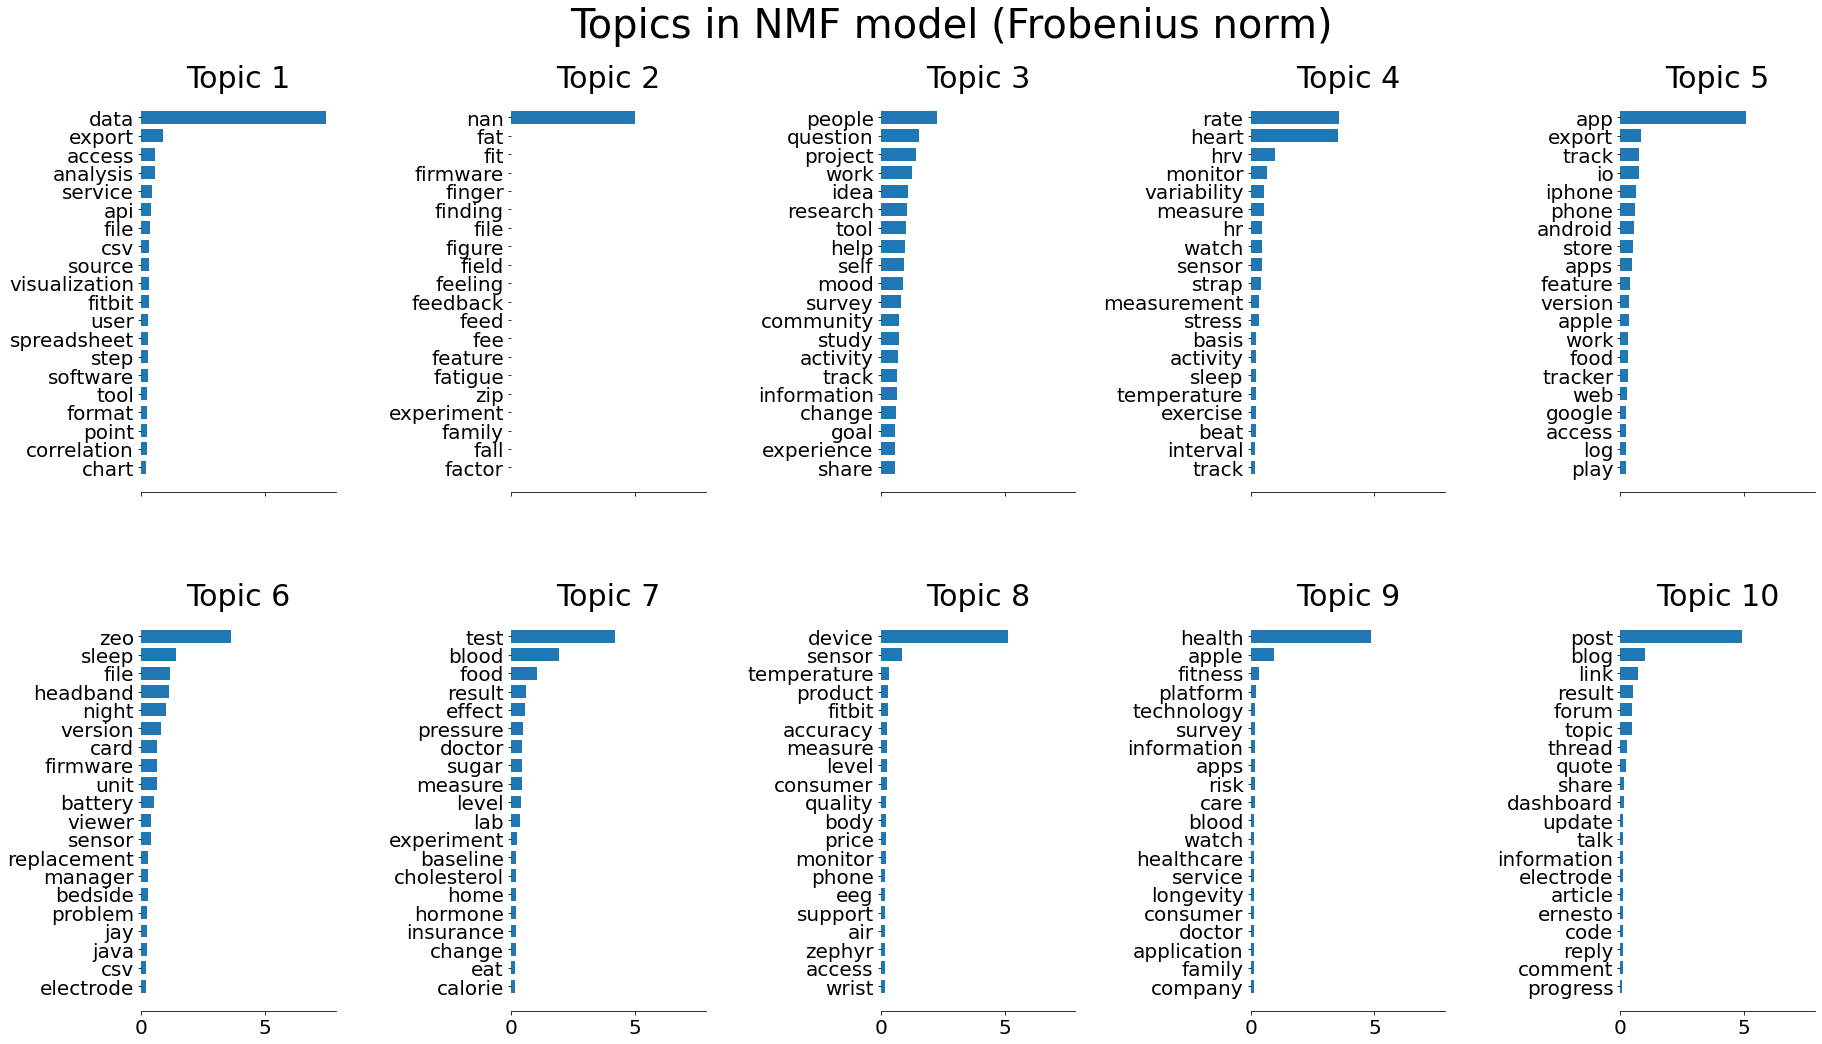

In [36]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))


tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (Frobenius norm)')



 Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=2000 and n_features=1000...


/home/criuser/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning:The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).


done in 1.615s.


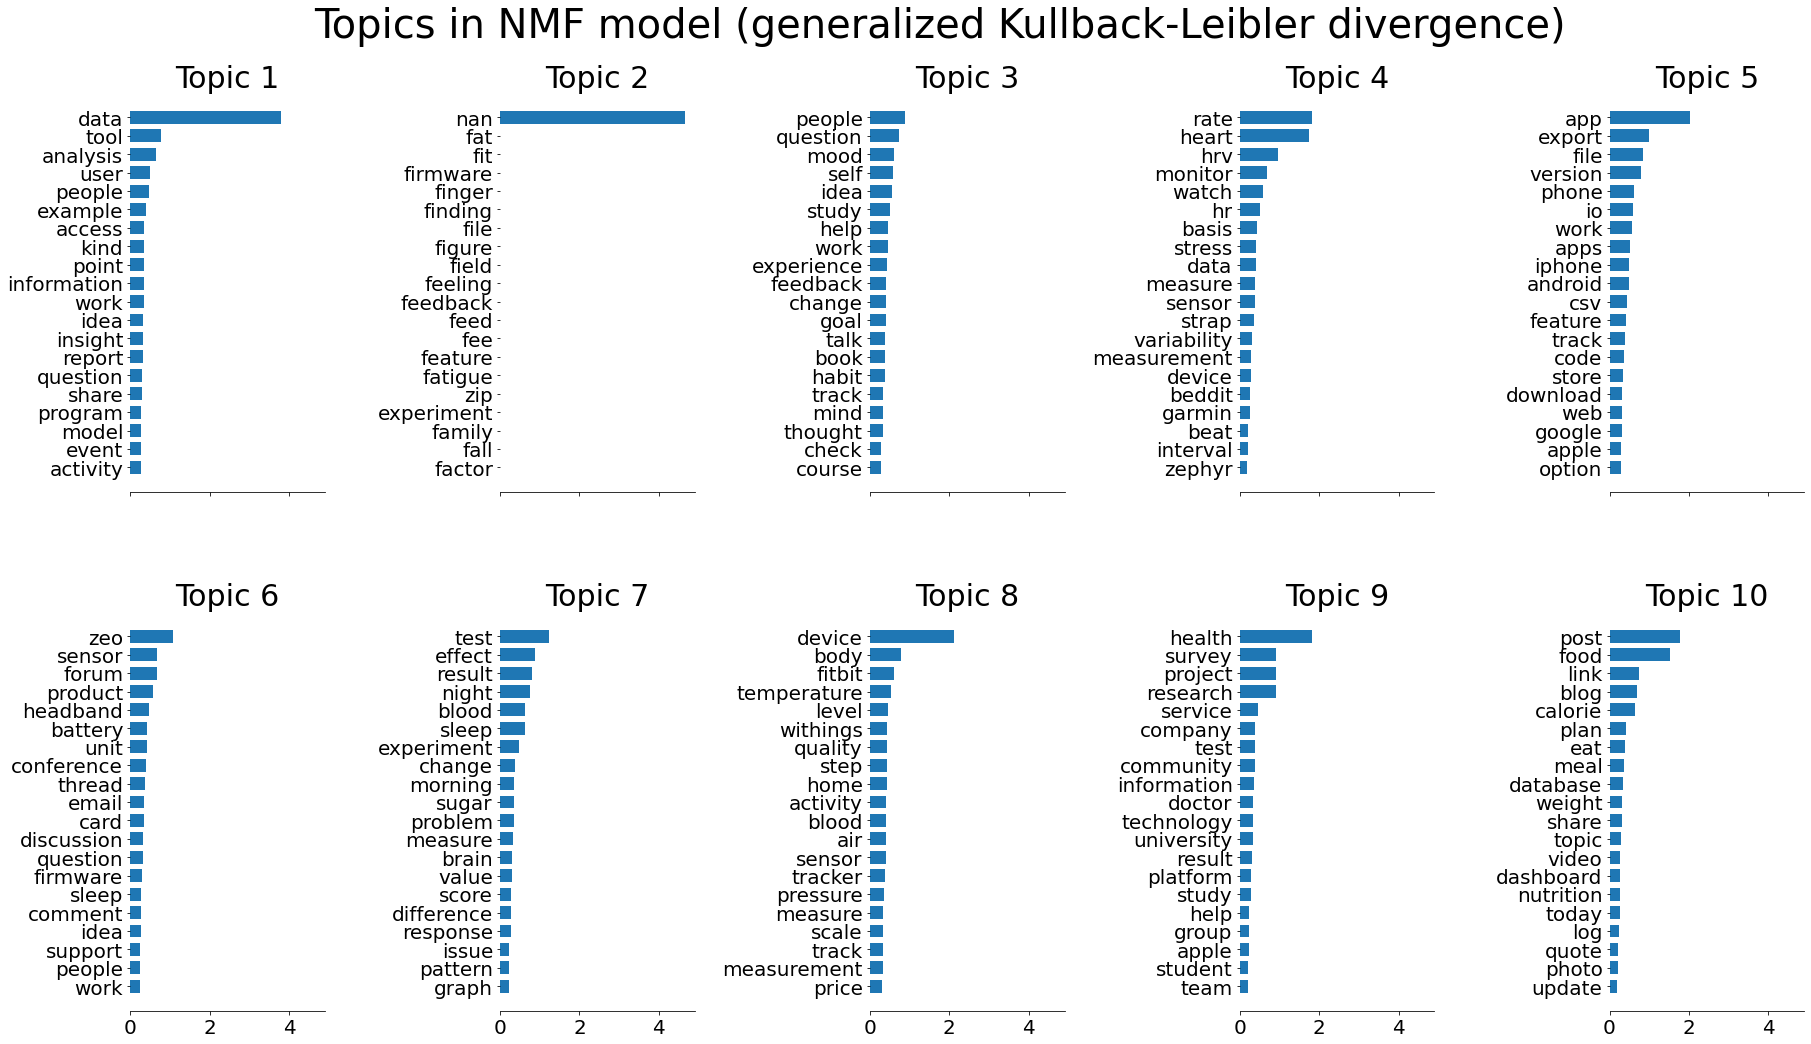

In [37]:
# Fit the NMF model
print('\n' * 2, "Fitting the NMF model (generalized Kullback-Leibler "
      "divergence) with tf-idf features, n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

t0 = time()
nmf = NMF(n_components=n_components, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidf)
print("done in %0.3fs." % (time() - t0))

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_top_words(nmf, tfidf_feature_names, n_top_words,
               'Topics in NMF model (generalized Kullback-Leibler divergence)')



 Fitting LDA models with tf features, n_samples=2000 and n_features=1000...
done in 7.704s.


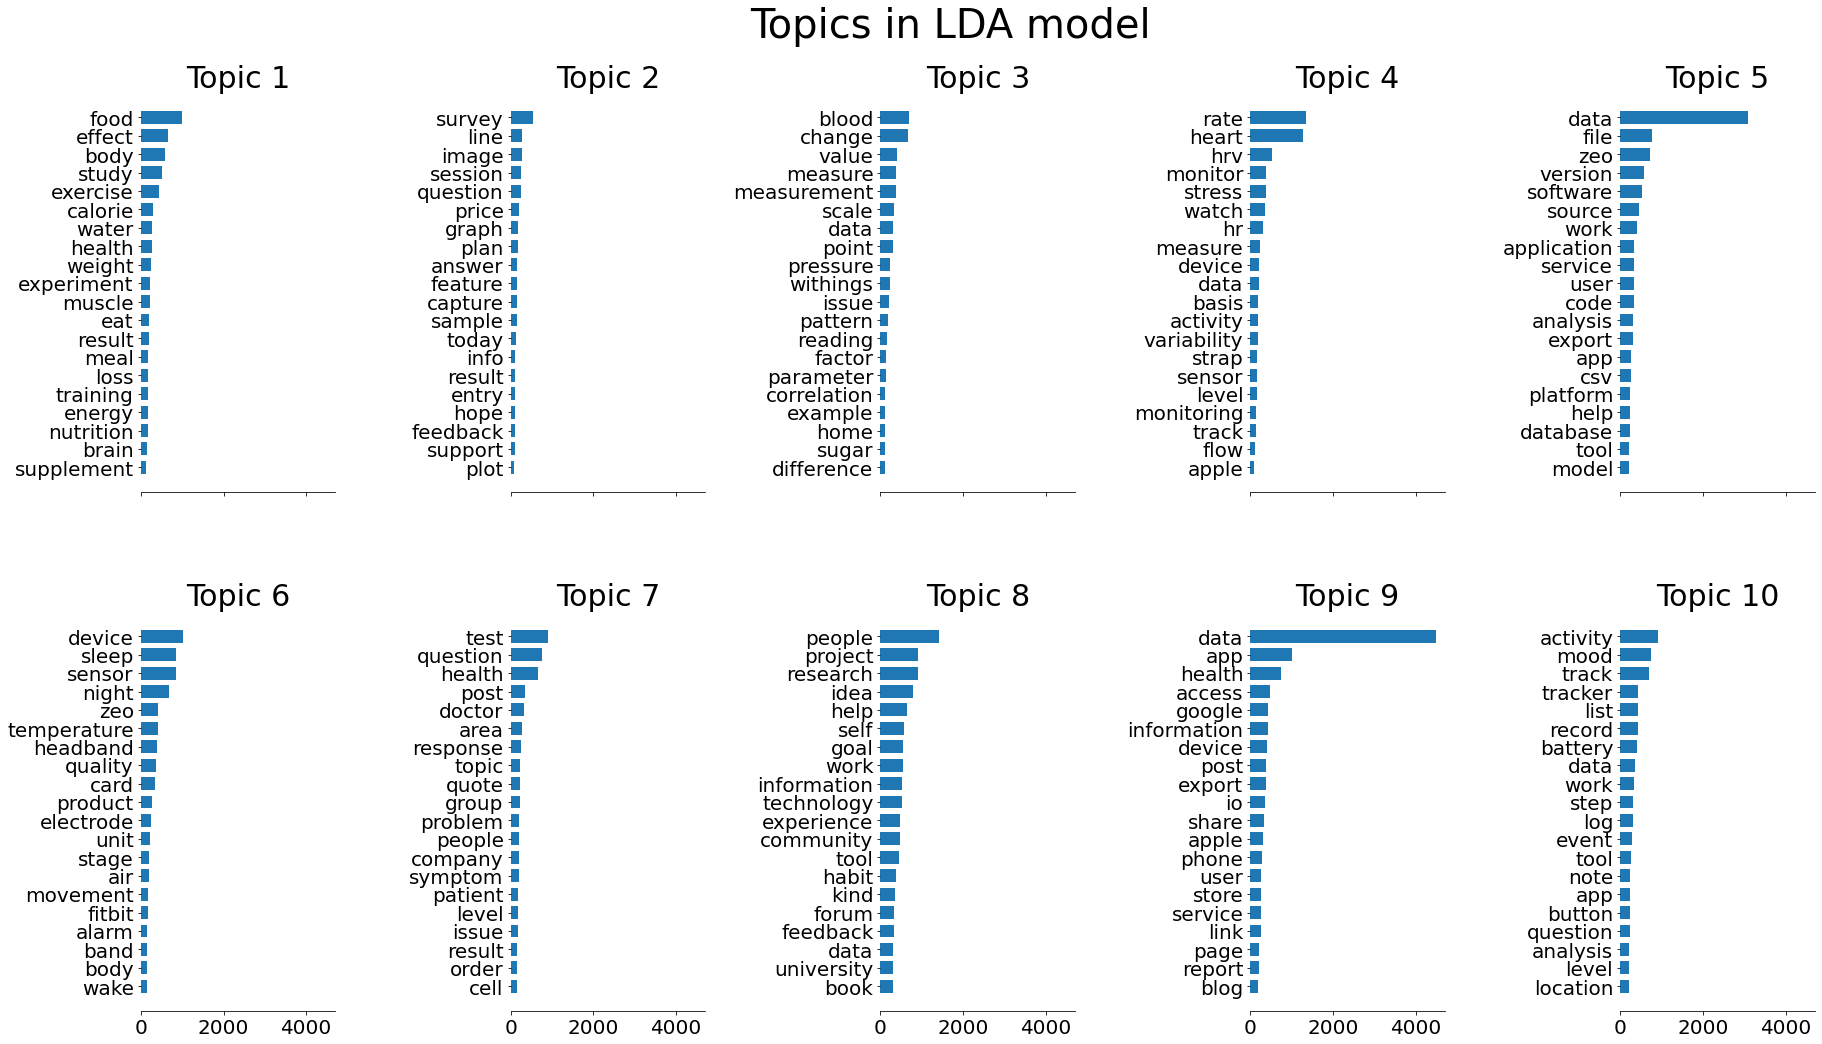

In [38]:
print('\n' * 2, "Fitting LDA models with tf features, "
      "n_samples=%d and n_features=%d..."
      % (n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
t0 = time()
lda.fit(tf)
print("done in %0.3fs." % (time() - t0))

tf_feature_names = tf_vectorizer.get_feature_names()
plot_top_words(lda, tf_feature_names, n_top_words, 'Topics in LDA model')

In [39]:
import pyLDAvis.sklearn

# 1 _ NMF model

In [40]:
pyLDAvis.enable_notebook()

vis_data = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer)
pyLDAvis.display(vis_data)

In [52]:
pip install bertopic

     |████████████████████████████████| 55 kB 342 kB/s eta 0:00:01
     |████████████████████████████████| 13.2 MB 1.4 MB/s eta 0:00:01
     |████████████████████████████████| 80 kB 431 kB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 297 kB/s eta 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 85 kB 57 kB/s eta 0:00:0101
  Using cached Cython-0.29.24-cp39-cp39-manylinux1_x86_64.whl (1.9 MB)
     |████████████████████████████████| 2.6 MB 1.1 MB/s eta 0:00:01
     |████████████████████████████████| 831.4 MB 5.2 kB/s eta 0:00:01    |▋                               | 17.1 MB 1.3 MB/s eta 0:10:15     |███                             | 76.5 MB 1.3 MB/s eta 0:09:35     |███████████                     | 284.9 MB 1.4 MB/s eta 0:06:42     |██████████████▊                 | 383.9 MB 1.4 MB/s eta 0:05:28     |███████████████████████████▋    | 718.3 MB 1.2 M

  Created wheel for sentence-transformers: filename=sentence_transformers-2.0.0-py3-none-any.whl size=126710 sha256=9a16798839a596f1372cebc75aca1ac1ae42d2293ea9e0e5bd58460fa2b1ac64
  Stored in directory: /home/criuser/.cache/pip/wheels/d6/08/96/83cc9ff48d2ba543e7e041eaa085713a12006b5b7ba0039a64
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76566 sha256=23c85f06aab7d9cde51c9f3b47ede3b15c977bff504bb1cae046a92e3b340609
  Stored in directory: /home/criuser/.cache/pip/wheels/43/2a/f2/52ebe2689efb2811a7f09527d3ab043b54467b43848639c1e1
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52358 sha256=598a4110511aeaf2d9186a2aee9e90816021c3c918c23471a08882819033607f
  Stored in directory: /home/criuser/.cache/pip/wheels/22/d3/c4/b9c26d3f7336f88188002b54b828c573b8bd4ee800bb5edc63
Successfully built hdbscan retrying sentence-transformers umap-learn pynndescent
  Attempting uninstall: plotly
    Found existing installation: plotly 5.0.

In [58]:
from bertopic import BERTopic

In [68]:
docs = global_df.lemma_LDA_text

In [67]:
type(global_df.lemma_LDA_text)

lux.core.series.LuxSeries

In [65]:
global_df.lemma_LDA_text

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

In [69]:
%%time
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/345 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/555 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/265M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/505 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [94]:
topic_model.save("BERTopic")

/home/criuser/miniconda3/lib/python3.9/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning:Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.


In [81]:
topic_model.get_topic_freq().sort_values(by='Count', ascending=False).head(10)

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

##### -1 refers to all outliers and should typically be ignored.

In [83]:
topic_model.get_topic(-1)

[('app', 0.012820435262760194),
 ('heart', 0.011478377392229941),
 ('sensor', 0.009801083824937),
 ('measure', 0.009764099710495302),
 ('health', 0.00952308370939516),
 ('research', 0.009469098916981266),
 ('user', 0.009349132722805695),
 ('analysis', 0.009095888306621436),
 ('test', 0.008977765877657317),
 ('mood', 0.00888861869664175)]

##### most frequent words in topic x

In [85]:
topic_model.get_topic(28)

[('sleep', 0.09680676070002558),
 ('headband', 0.02520841668517598),
 ('alarm', 0.02318943151510862),
 ('wake', 0.01936595302088045),
 ('bed', 0.019329092221428663),
 ('emfit', 0.018593680575065694),
 ('beddit', 0.012943331362206103),
 ('monitor', 0.012221366978853464),
 ('bedside', 0.011910557222043941),
 ('morning', 0.0110132503724361)]

In [91]:
topic_model.visualize_topics()

/home/criuser/miniconda3/lib/python3.9/site-packages/umap/umap_.py:125: UserWarning:A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 400 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.


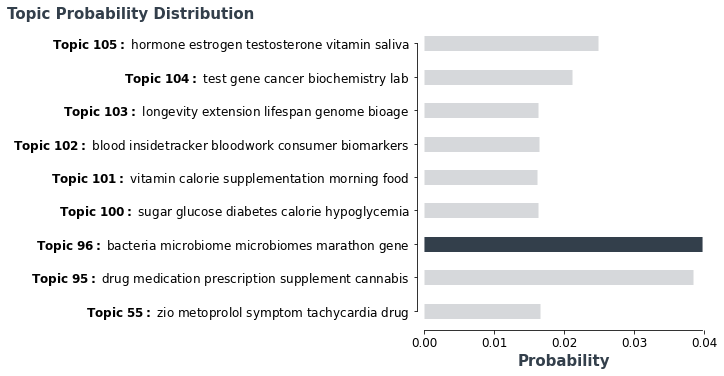

In [93]:
topic_model.visualize_distribution(probs[28])

## Topic Reduction

In [95]:
model = BERTopic(nr_topics=20)

In [98]:
#  reduce the number of topics when a pair of topics is found that exceeds a minimum similarity of 0.9

model = BERTopic(nr_topics="auto")

In [101]:
%%time
model = BERTopic()
topics, probs = model.fit_transform(docs)

CPU times: user 13min 32s, sys: 30.9 s, total: 14min 2s
Wall time: 2min 57s


In [102]:
new_topics, new_probs = model.reduce_topics(docs, topics, probs, nr_topics=30)

In [103]:
model.update_topics(docs, topics, n_gram_range=(1, 3), stop_words="english")

In [104]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range=(1, 3), stop_words="english")
model.update_topics(docs, topics, vectorizer=cv)